# Impact of disclosure control on outliers 

This notebook will show how using the metasyn-disclosure package can help reduce the impact of outliers on the results of the distribution fitting. 

## Setup

This notebook relies on having the metasyn-disclosure and matplotlib packages installed. If you don't have them installed, you can install them by uncommenting the following lines and running them. 

In [16]:
# !pip install git+https://github.com/sodascience/metasyn-disclosure-control.git
# !pip install matplotlib

The following code imports the necessary packages.

In [17]:
from collections import defaultdict

import numpy as np
import polars as pl
from metasyn.provider import DistributionProviderList
from metasyn.distribution import MultinoulliDistribution
from metasyncontrib.disclosure import DisclosurePrivacy
from matplotlib import pyplot as plt

## Outliers

First, we define a plotting function, which will help plot the impact of outliers for different distributions. It generates a series of plots showing the influence of outliers on various parameters of the distribution.

In [18]:
def plot_outliers(dist_type, series_size=50):
    # Create a list of distribution providers
    dist_providers = DistributionProviderList(["builtin", "metasyn-disclosure"])
    
    # Get the distributions for the given type with disclosure control
    disc_distributions = dist_providers.get_distributions(
        var_type=dist_type, privacy=DisclosurePrivacy()
    )

    # Iterate over distributions
    for disc_class in disc_distributions:
        if issubclass(disc_class, MultinoulliDistribution):
            continue
        
        # Find the base class of the disclosure distribution
        base_class = dist_providers.find_distribution(disc_class.implements, disc_class.var_type)
    
        # Get the default distribution of the base class
        dist = base_class.default_distribution()
        
        # Draw a series of random values
        series = pl.Series([dist.draw() for _ in range(series_size)])
        
        # Fit the distribution to the series
        clean_base_param = base_class.fit(series).to_dict()["parameters"]
        clean_disc_param = disc_class.fit(series).to_dict()["parameters"]
        
        # Initialize dictionaries to store the parameters of the distributions
        base_param = defaultdict(lambda: [])
        disc_param = defaultdict(lambda: [])

        # Helper function to add parameters
        def _add(parameters, param, new_val):
            for key, val in param.items():
                parameters[key].append(val)
            parameters["new_val"].append(new_val)

        # Iterate over a range of values
        for new_val in np.linspace(-100, 100, 51):
            # Add a new value to the series
            new_series = series.extend_constant(new_val, 1)
            
            # Fit the distributions to the new series
            base_dist = base_class.fit(new_series)
            disc_dist = disc_class.fit(new_series)
            
            # Add the parameters of the fitted distributions to the dictionaries
            _add(base_param, base_dist.to_dict()["parameters"], new_val)
            _add(disc_param, disc_dist.to_dict()["parameters"], new_val)

        # Plot the differences between the base and disclosure distributions for each value
        for param in base_param:
            if param == "new_val":
                continue
            
            # Create plot for the base distribution
            plt.plot(
                base_param["new_val"],
                np.array(base_param[param]) - clean_base_param[param],
                label="base",
            )
            
            # Create plot for the disclosure distribution
            plt.plot(
                disc_param["new_val"],
                np.array(disc_param[param]) - clean_disc_param[param],
                label="disclosure",
            )
            
            # Set the title, labels and show the plot
            plt.title(f"{disc_class.__name__}: {param}")
            plt.ylabel("Difference between dist with and without outlier")
            plt.xlabel("Value of the outlier")
            plt.legend()
            plt.show()

### Graphs for all continuous distributions

Using the function above, we can now plot the impact of outliers for all continuous distributions.

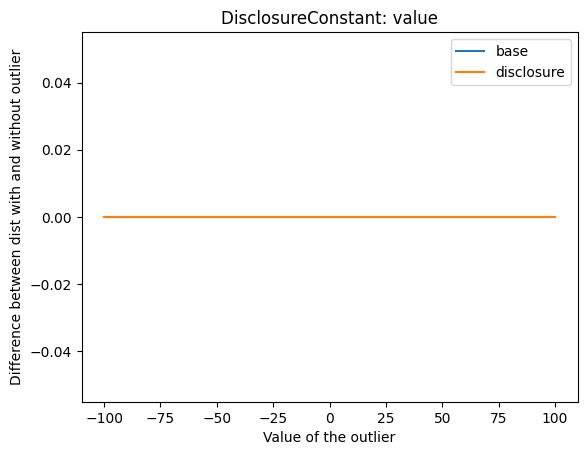

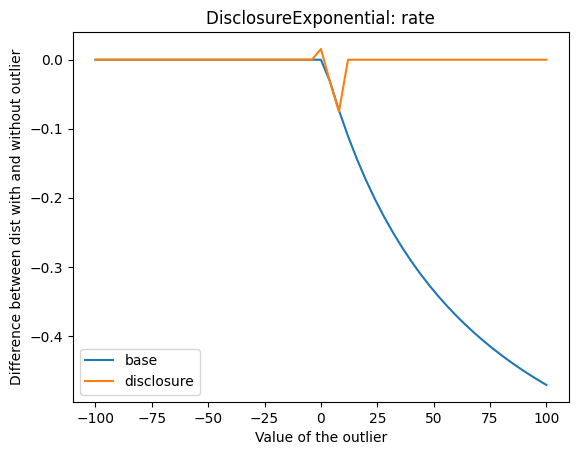

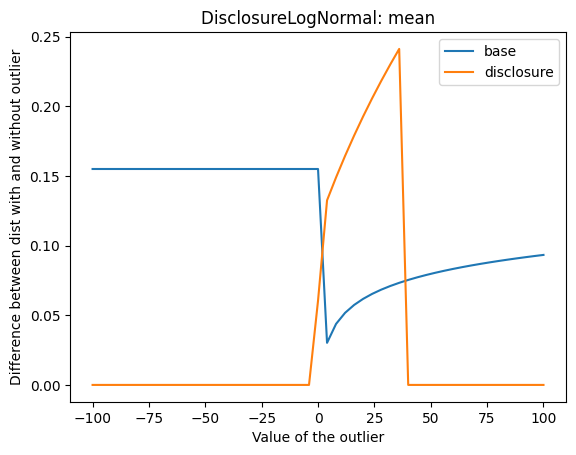

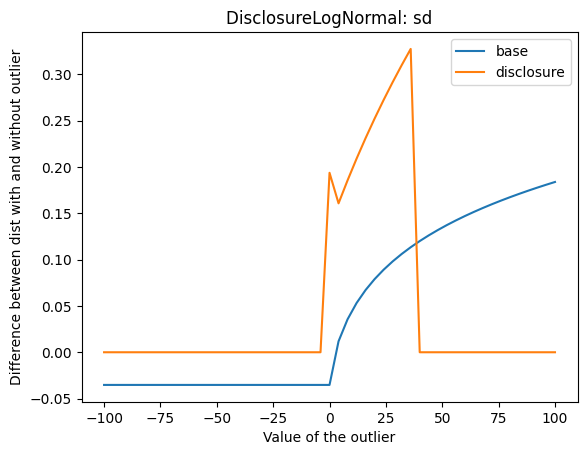

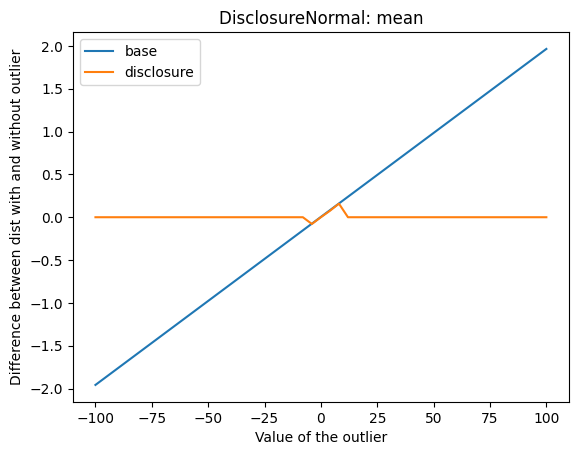

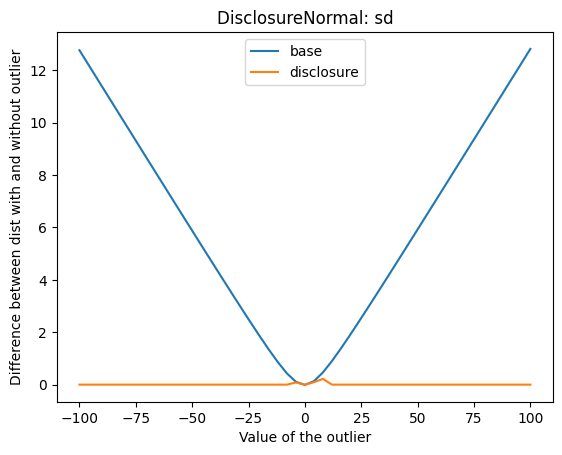

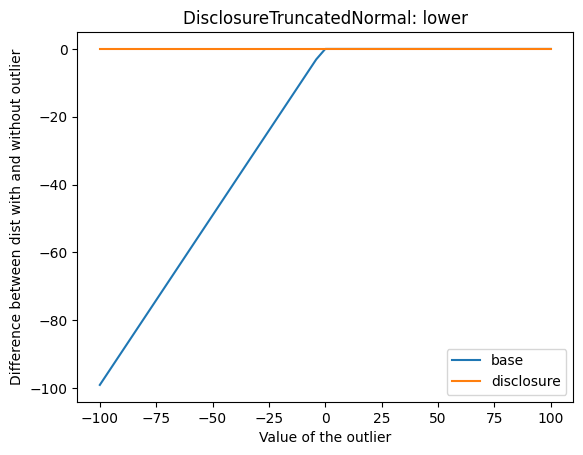

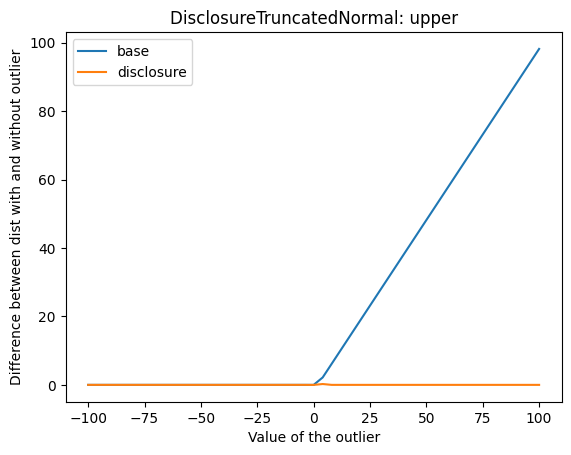

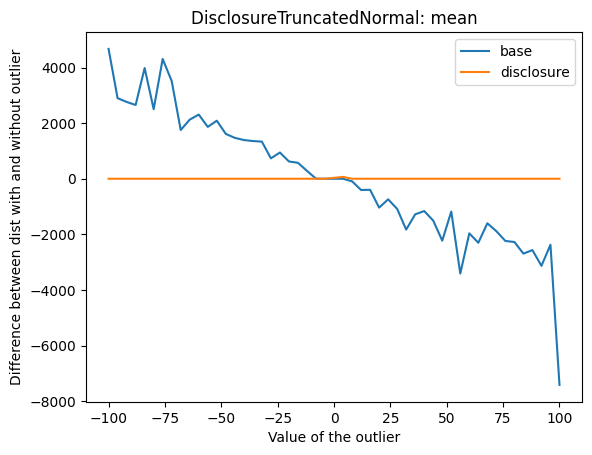

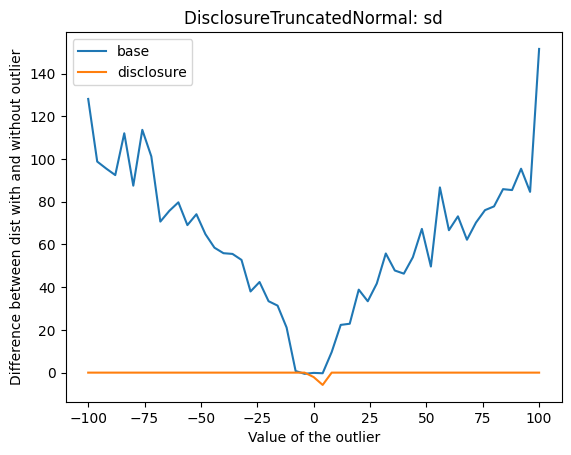

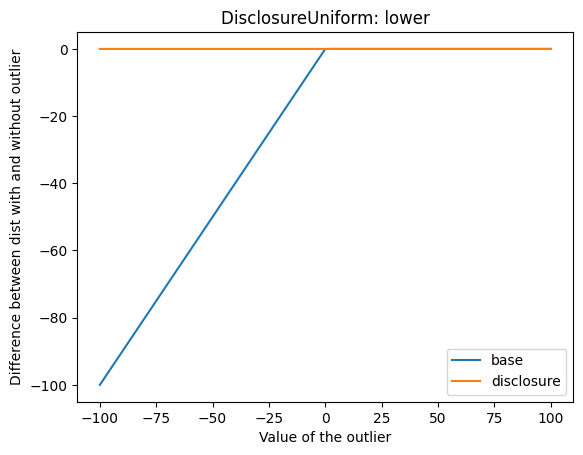

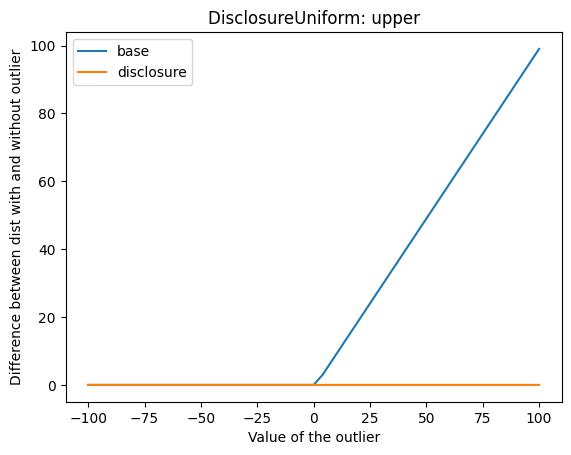

In [19]:
plot_outliers("continuous")

As we can see, the effect from outliers is much reduced compared to the baseline implementation. For all of the distributions, the change in the result is much smaller when an outlier is added.

### Graphs for all discrete distributions

We can also plot the impact of outliers for all discrete distributions.

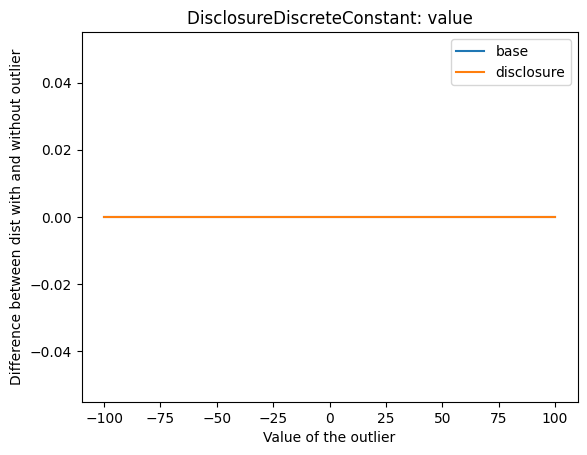

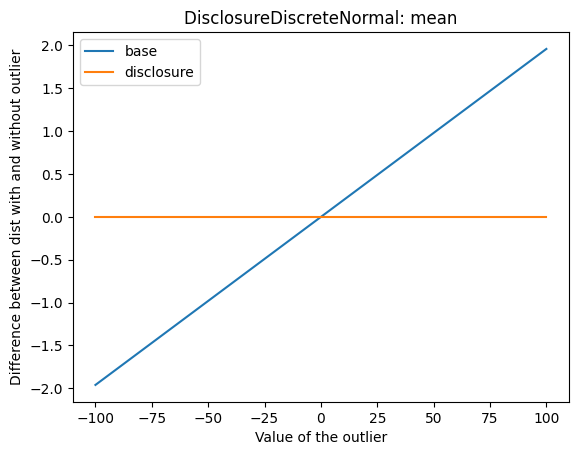

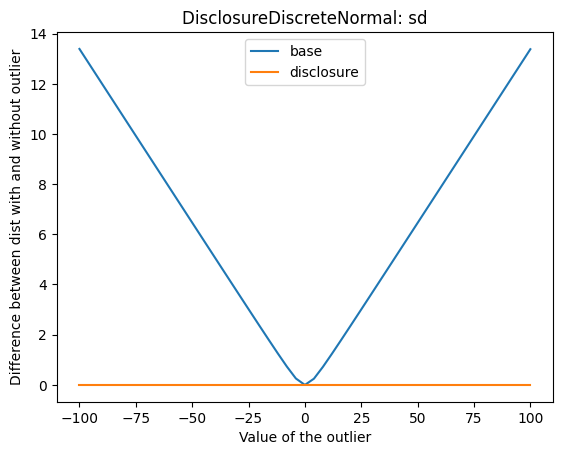

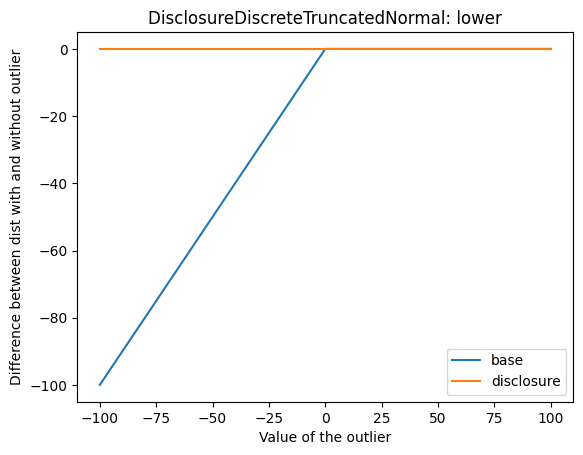

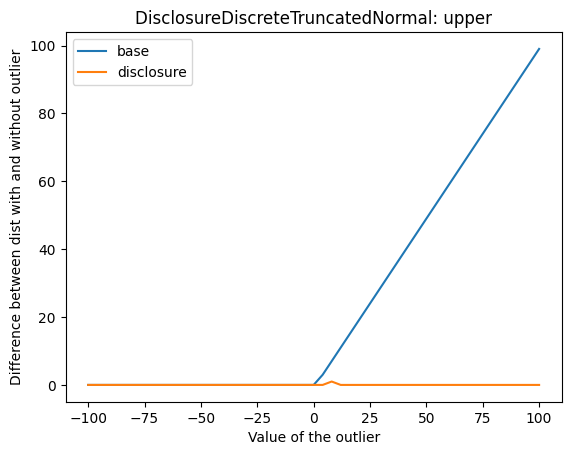

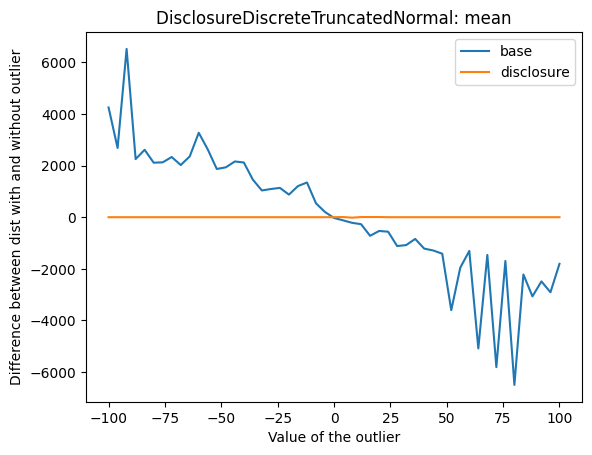

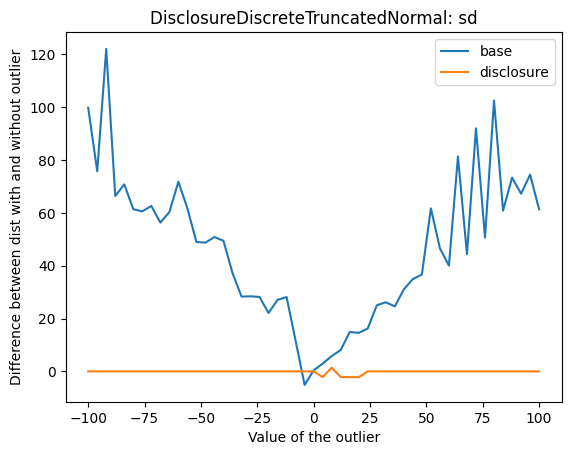

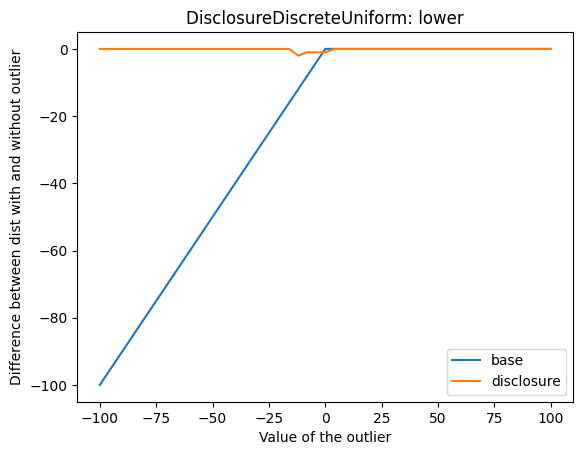

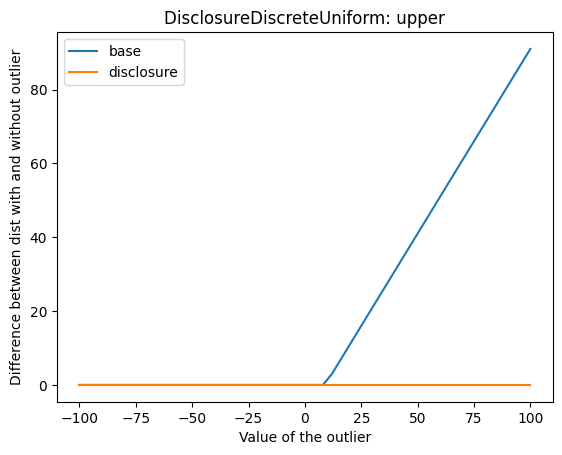

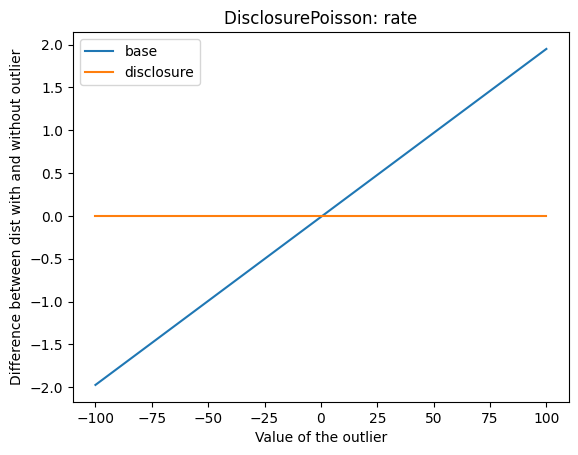

In [20]:
plot_outliers("discrete")

The same is true for the discrete distributions, only a localized effect is present.